In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

In [2]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [3]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.5822137847288081
Explained variance ratio for 10 components: 0.7008253078161787
Explained variance ratio for 15 components: 0.7601916237178342
EOFs shape for 5 components: (eof, lat, lon) (5, 13, 35)
EOFs shape for 10 components: (eof, lat, lon) (10, 13, 35)
EOFs shape for 15 components: (eof, lat, lon) (15, 13, 35)
PCs shape for 5 components: (eof, time) (5, 864)
PCs data for 5 components: <xarray.DataArray (eof: 5, time: 864)>
array([[ -6.29767607,  -6.92623833,  -6.06612333, ...,  -8.78229121,
        -10.73037298, -11.51841333],
       [ -1.32017403,  -0.94989195,  -0.17729698, ...,   3.58378538,
          3.30997493,   0.36169658],
       [ -2.06665413,  -2.59613459,  -2.82771558, ...,  -3.41826837,
         -4.84755374,  -4.01489501],
       [  0.20367227,   0.53551661,  -0.37872963, ...,  -1.01850818,
         -0.44632027,  -1.55271228],
       [ -0.18501612,   1.66551048,   1.91977222, ...,  -0.8067989 ,
          0.88245436,   1.137

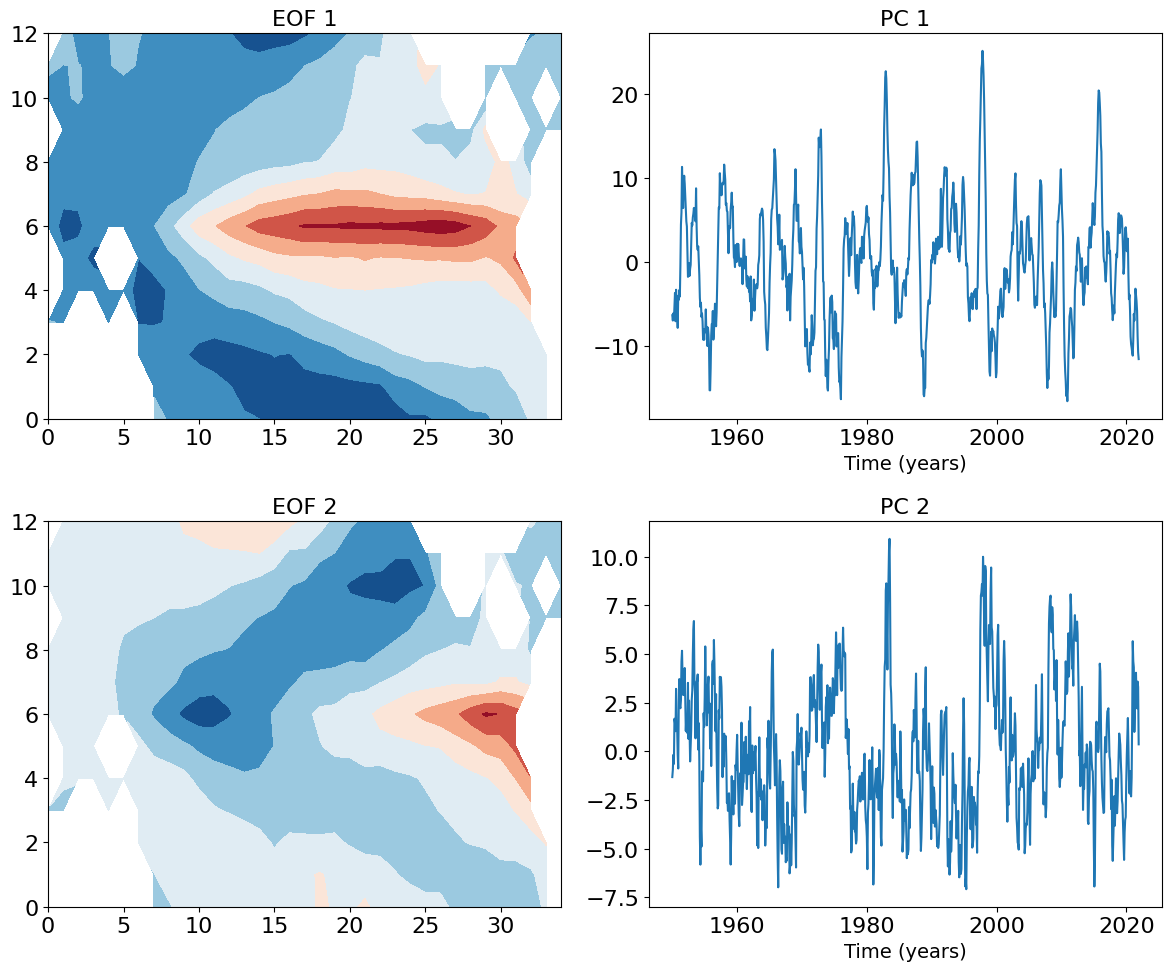

In [4]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [5]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [6]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Eigenvalues - real: [0.89887776 0.87550237 0.87550237 0.85422139 0.85422139 0.80582083
 0.74999239 0.69131228 0.69131228 0.660626  ]
Frobenius norm: 0.7288028449229786
Data train : [[-6.29767607 -6.92623833 -6.06612333 ... -5.33055296 -4.86835222
  -6.0603949 ]
 [-1.32017403 -0.94989195 -0.17729696 ... -2.09860531 -2.16949402
  -2.62321542]
 [-2.06665349 -2.59613491 -2.8277156  ... -1.22104007 -2.50958123
  -1.09307037]
 ...
 [ 0.46666117  0.63492009  0.63564749 ... -5.22354459 -5.79771919
  -3.26079853]
 [ 1.10642454  0.45351603  0.14074054 ...  1.62787668 -0.1729356
   1.00821715]
 [ 1.58589154  1.44628636  2.32705872 ... -0.99156829 -0.78498878
  -0.7906976 ]] + shape: (10, 691)


In [7]:
# Model geometric brownian motion

#model.geometric_brownian_motion(mu=2)


In [8]:
# Numerical integration of stochastic process using euler_maruyama method
#model.euler_maruyama(input_data)

In [9]:
# Simulate stochastic differential equation
# Input: Y0, L, Q, T, dt
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

model.euler_maruyama(x, 100, 2)

#model.simulate_sde(x, 100, 2)

Browninan Motion: [ 0.1435732  -0.05407214 -0.04668423 -0.09483792  0.07649195 -0.2034292
  0.15422103 -0.06728182  0.02819934 -0.02204144  0.1292333  -0.18209243
 -0.02849792 -0.03394593  0.10021201 -0.09721757 -0.01524064 -0.07759246
  0.0037312   0.05151407 -0.09728191  0.10118024  0.07969011  0.04441464
  0.07962517 -0.06043358 -0.01086206 -0.08271111 -0.02367818  0.04687724
 -0.06113475 -0.03506839 -0.06073806 -0.07470633 -0.05933034 -0.0011194
 -0.09875722  0.02071962  0.14670717  0.06558806 -0.01695603 -0.07845606
 -0.06604009  0.14959327  0.00449081 -0.05630299  0.0168747   0.18563808
  0.01062065  0.05455356  0.02653156 -0.03113478 -0.1009853  -0.03087783
 -0.01846382  0.05185065  0.07415636  0.08229857  0.02524259  0.07823616
 -0.06667999  0.11073895  0.04533702 -0.02634793  0.04317931 -0.00667966
  0.10002285  0.1343341   0.1931794  -0.123434   -0.12764283 -0.0445889
  0.01414541  0.07744312  0.02789845 -0.17873902 -0.02706487  0.07318331
  0.02033769  0.06735291 -0.01965122

NameError: name 'Y' is not defined

In [ ]:
#Create forecast with LIM using forecast lag

lag = 2

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data
# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

print("Forecasting mean using LIM model : {}".format(x_frcst))

In [ ]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
# Forecasting

# Define lag
lag = 3

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

In [ ]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")